<a href="https://colab.research.google.com/github/FoxHound0x00/CS6960-HDDA/blob/main/HW3/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [9]:
!nvidia-smi

Fri Nov  1 19:59:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
!sudo apt-get install libomp-dev
!pip install faiss-gpu-cu12
!pip install nltk
!pip install gensim

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [18]:
import faiss
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import numpy as np



warnings.filterwarnings(action='ignore')
from urllib.request import urlopen
import json

str_ = "https://github.com/dwyl/english-words/raw/refs/heads/master/words_dictionary.json"


In [19]:
def scrape_data(url):
    with urlopen(url) as response:
        data = response.read()
        return json.loads(data)

In [20]:
data = scrape_data(str_)
print("Data scraped successfully.")
words_ = data.keys()
len_ = len(words_)
print(f"Number of words in the English dictionary: {len_}")

Data scraped successfully.
Number of words in the English dictionary: 370100


In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwd

--2024-11-01 20:11:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-01 20:11:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-01 20:11:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [21]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [24]:
glove_file = "glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_file)
print("GloVe embeddings loaded successfully.")

GloVe embeddings loaded successfully.


In [25]:
filtered_words = [word for word in words_ if word in glove_embeddings]
vectors = np.array([glove_embeddings[word] for word in filtered_words])



In [26]:
embedding_dim = vectors.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(vectors)
print(f"FAISS index has been created and populated with {index.ntotal} word embeddings.")


FAISS index has been created and populated with 100778 word embeddings.


In [32]:
# Randomly sampling 1000 words
import time
import random
sampled_words = random.sample(filtered_words, 1000)
sampled_vectors = np.array([glove_embeddings[word] for word in sampled_words])


In [33]:
# Cosine-Sim
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

In [34]:
def brute_force_top_n(sampled_vectors, all_vectors, n=5):
    times = []
    for vec in sampled_vectors:
        start_time = time.time()
        similarities = [cosine_similarity(vec, other_vec) for other_vec in all_vectors]
        top_n_indices = np.argsort(similarities)[-n:][::-1]
        times.append(time.time() - start_time)
    avg_time = np.mean(times)
    print(f"Average brute-force search time for top-{n} neighbors: {avg_time:.5f} seconds")
    return avg_time

In [35]:
def faiss_top_n(sampled_vectors, index, n=5):
    times = []
    for vec in sampled_vectors:
        vec = vec.reshape(1, -1)
        start_time = time.time()
        _, indices = index.search(vec, n)
        times.append(time.time() - start_time)
    avg_time = np.mean(times)
    print(f"Average FAISS search time for top-{n} neighbors: {avg_time:.5f} seconds")
    return avg_time

In [36]:
avg_time_bf = brute_force_top_n(sampled_vectors, vectors, n=5)
avg_time_faiss = faiss_top_n(sampled_vectors, index, n=5)


Average brute-force search time for top-5 neighbors: 0.88115 seconds
Average FAISS search time for top-5 neighbors: 0.01476 seconds


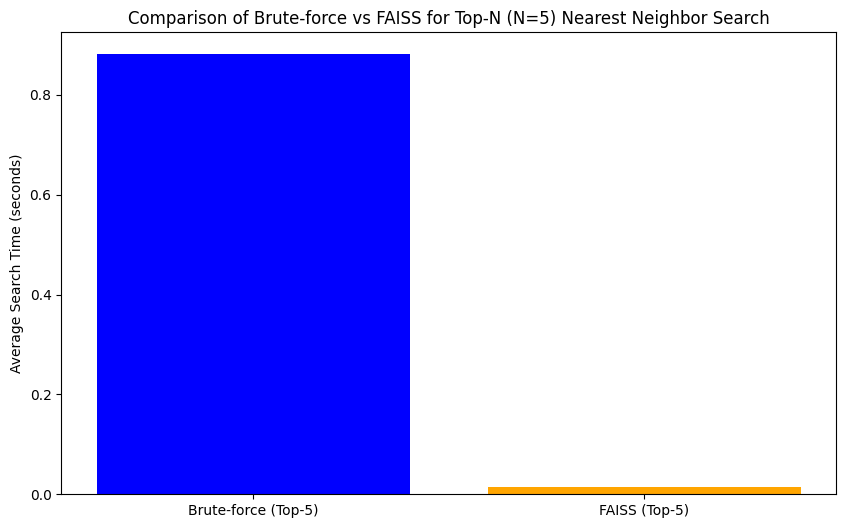

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
methods = ['Brute-force (Top-5)', 'FAISS (Top-5)']
times = [avg_time_bf, avg_time_faiss]
plt.bar(methods, times, color=['blue', 'orange'])
plt.ylabel('Average Search Time (seconds)')
plt.title('Comparison of Brute-force vs FAISS for Top-N (N=5) Nearest Neighbor Search')
plt.show()